In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

In [8]:
trainPath = 'C:\\Users\\sazid\\Desktop\\data\\all_three\\train'
valPath = 'C:\\Users\\sazid\\Desktop\\data\\all_three\\valid'
testPath = 'C:\\Users\\sazid\\Desktop\\data\\all_three\\test'

In [9]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects

testAug=ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean
testAug.mean = mean

In [10]:
# initialize the training generator
batch_size = 32
trainGen = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size)
# initialize the validation generator
valGen = valAug.flow_from_directory(
    valPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size)
# initialize the testing generator
testGen = testAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size)

Found 5006 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [11]:
## load the ResNet-50 network, ensuring the head FC layer sets are left
# off
print("[INFO] preparing model...")
baseModel = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers[:168]:
    layer.trainable = False
for layer in baseModel.layers[168:]:
    layer.trainable=True

model.summary() 

# Make sure you have frozen the correct layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

[INFO] preparing model...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________

In [12]:
totalTrain=5006
totalVal=1000
epochs=100
#from keras.optimizers import SGD
print("compiling model...")
#opt = SGD(lr=1e-4, momentum=0.9)
learning_rate=1e-4
opt = Adam(lr=learning_rate, decay=learning_rate / epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["acc"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("training head...")
H = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // batch_size,
    validation_data=valGen,
    validation_steps=totalVal // batch_size,
    epochs=epochs)

compiling model...
training head...
Epoch 1/100
156/156 [==============================] - 237s 2s/step - loss: 1.4116 - acc: 0.4128 - val_loss: 0.8328 - val_acc: 0.6361
Epoch 2/100
156/156 [==============================] - 224s 1s/step - loss: 0.8787 - acc: 0.6310 - val_loss: 0.6102 - val_acc: 0.7359
Epoch 3/100
156/156 [==============================] - 226s 1s/step - loss: 0.7426 - acc: 0.6818 - val_loss: 0.5370 - val_acc: 0.7853
Epoch 4/100
156/156 [==============================] - 226s 1s/step - loss: 0.6241 - acc: 0.7359 - val_loss: 0.4999 - val_acc: 0.8085
Epoch 5/100
156/156 [==============================] - 239s 2s/step - loss: 0.5471 - acc: 0.7722 - val_loss: 0.4781 - val_acc: 0.8276
Epoch 6/100
156/156 [==============================] - 241s 2s/step - loss: 0.4980 - acc: 0.8047 - val_loss: 0.4589 - val_acc: 0.8357
Epoch 7/100
156/156 [==============================] - 219s 1s/step - loss: 0.4474 - acc: 0.8257 - val_loss: 0.4893 - val_acc: 0.8175
Epoch 8/100
156/156 [=====

In [13]:
model.save("multi_resnet_finetune.h5")

In [14]:
target_names = []
for key in trainGen.class_indices:
    target_names.append(key)
    
print(target_names)


['background', 'lizard', 'snake', 'toad']


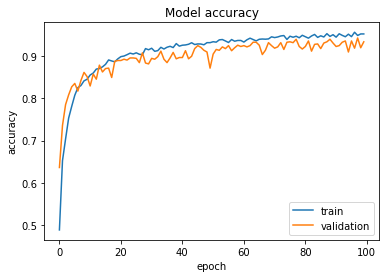

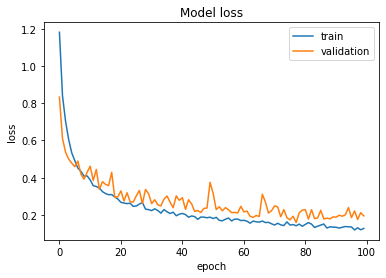

In [15]:
############################################
#Plot the Graph

acc = H.history['acc']
val_acc = H.history['val_acc']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('acc.png')
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('loss.png')
plt.show()

In [16]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("evaluating after fine-tuning network head...")

totalTest=400
testGen.reset()
predIdxs = model.predict(x=testGen, steps=(totalTest // batch_size) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
    target_names=testGen.class_indices.keys()))

evaluating after fine-tuning network head...
              precision    recall  f1-score   support

  background       0.78      0.60      0.68       100
      lizard       0.71      0.97      0.82       100
       snake       0.95      0.92      0.93       100
        toad       0.99      0.89      0.94       100

    accuracy                           0.84       400
   macro avg       0.86      0.84      0.84       400
weighted avg       0.86      0.84      0.84       400



Confusion matrix, without normalization


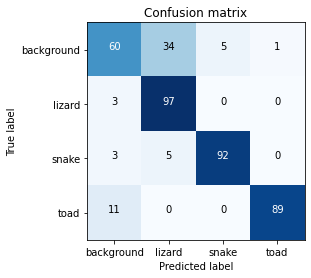

In [17]:
from sklearn.metrics import confusion_matrix
import itertools 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.figure(figsize=(8,8))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   

#thresh = cm.max() / 2.
#Matplotlib’s matshow
cm = confusion_matrix(testGen.classes, predIdxs)

plt.figure(3)
plot_confusion_matrix(cm, target_names, title='Confusion matrix')
#print(cm)
plt.savefig('snake_Resnet.png')
plt.show()